In [40]:
import warnings
warnings.filterwarnings('ignore')

# ZTDL 1

C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


Pareto Front Points: [[0.74755656 0.13538647]
 [0.70782625 0.15867589]
 [0.4080557  0.36120763]
 [0.55739195 0.25341313]
 [0.50384544 0.29017929]
 [0.         1.        ]]


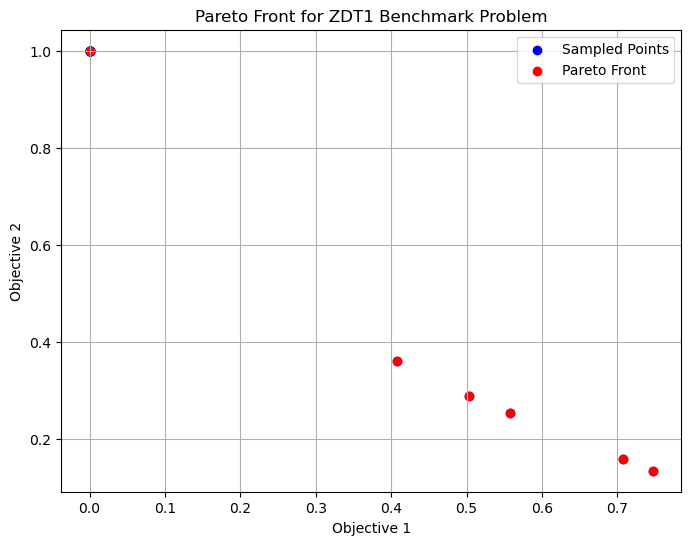

Hypervolume: 2.272480651656203


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

class GaussianProcess:
    def __init__(self, noise_var=1e-10):
        self.noise_var = noise_var
        self.X_train = None
        self.y_train = None
        self.K_inv = None

    def kernel(self, x1, x2, l=1.0, sigma_f=1.0):
        """ Squared Exponential Kernel """
        sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        K = self.kernel(X, X) + self.noise_var * np.eye(len(X))
        self.K_inv = np.linalg.inv(K)

    def predict(self, X_s):
        K_s = self.kernel(self.X_train, X_s)
        K_ss = self.kernel(X_s, X_s) + 1e-8 * np.eye(len(X_s))
        K_inv = self.K_inv
        
        mu_s = K_s.T.dot(K_inv).dot(self.y_train)
        cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
        
        return mu_s.ravel(), np.diag(cov_s)

def zdt1(x):
    f1 = x[:, 0]
    g = 1 + 9 * (np.sum(x[:, 1:], axis=1) / 29)
    f2 = g * (1 - np.sqrt(f1 / g))
    return np.column_stack((f1, f2))

def is_pareto_efficient(costs):
    """
    Find the Pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A boolean array of Pareto-efficient points
    """
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

def is_dominating(y, PF):
    """
    Check if vector y dominates the Pareto front approximation.
    
    Parameters:
    - y (numpy.ndarray): A vector sampled from the multivariate normal distribution.
    - PF (numpy.ndarray): The Pareto front approximation vector.
    
    Returns:
    - bool: True if y dominates PF, False otherwise.
    """
    return np.all(y < PF)

def calculate_cPoI(mu, sigma, PF, n_samples):
    """
    Calculate the Correlated Probability of Improvement using Monte Carlo simulation.
    
    Parameters:
    - mu (numpy.ndarray): The mean vector of the multivariate normal distribution.
    - sigma (numpy.ndarray): The covariance matrix of the multivariate normal distribution.
    - PF (numpy.ndarray): The Pareto front approximation set.
    - n_samples (int): Number of samples to draw in the Monte Carlo simulation.
    
    Returns:
    - float: The calculated cPoI value.
    """
    count = 0
    for _ in range(n_samples):
        y_tilde = multivariate_normal.rvs(mean=mu, cov=sigma)
        if is_dominating(y_tilde, PF):
            count += 1
    return count / n_samples

def optimize(gp, X_train, y_train, bounds, n_iter=25):
    """ Run Bayesian optimization process """
    gp.fit(X_train, y_train)
    
    for i in range(n_iter):
        # Calculate the mean and covariance matrix for the current Gaussian process
        X_s = np.linspace(bounds[0], bounds[1], 100)[:, None]
        mu, sigma = gp.predict(X_s)
        
        # Calculate the cPoI for each point in the bounds
        cPoIs = np.array([calculate_cPoI(mu[i], sigma[i], y_train, n_samples=1000) for i in range(len(X_s))])
        
        # Select the next point with the highest cPoI
        x_next = X_s[np.argmax(cPoIs)]
        y_next = zdt1(x_next.reshape(-1, 1))
        
        # Update the data and re-fit the GP
        X_train = np.vstack((X_train, x_next))
        y_train = np.vstack((y_train, y_next))
        gp.fit(X_train, y_train)
        
    return X_train, y_train

def hypervolume_indicator(front, reference_point):
    """
    Compute the hypervolume indicator of a Pareto front approximation.

    Parameters:
        front (list of tuples): List of points representing the Pareto front.
                                Each tuple contains the objective values of a point.
        reference_point (tuple): The reference point used for calculation.
                                 It should dominate all points in the front.

    Returns:
        hypervolume (float): The hypervolume indicator value.
    """

    # Sort the front based on the first objective (ascending order)
    sorted_front = sorted(front, key=lambda x: x[0])

    # Initialize hypervolume to zero
    hypervolume = 0.0

    # Iterate through each point in the front
    for point in sorted_front:
        # Calculate the contribution of the current point to the hypervolume
        contribution = 1.0
        for i in range(len(reference_point)):
            contribution *= max(0, reference_point[i] - point[i])
        # Add the contribution to the hypervolume
        hypervolume += contribution

    return hypervolume



# Bounds for the input
bounds = (0, 1)
# Initial random samples
X_initial = np.random.uniform(bounds[0], bounds[1], (5, 1))
y_initial = zdt1(X_initial)

# Initialize and run the Gaussian Process
gp = GaussianProcess()
X_final, y_final = optimize(gp, X_initial, y_initial, bounds)

# Determine Pareto front
pareto_mask = is_pareto_efficient(y_final)
pareto_front = y_final[pareto_mask]
print("Pareto Front Points:", pareto_front)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(y_final[:, 0], y_final[:, 1], color='blue', label='Sampled Points')
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], color='red', label='Pareto Front')
plt.title('Pareto Front for ZDT1 Benchmark Problem')
plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.legend()
plt.grid(True)
plt.show()

reference_point = [1.1, 1.1]  # You need to choose a reference point that dominates all solutions

# Calculate hypervolume
hypervolume = hypervolume_indicator(pareto_front, reference_point)
print("Hypervolume:", hypervolume)

In [20]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from MOMF_problems import MOMF3_5_1
problem = MOMF3_5_1()

def objective_function(x, fidelity):
    x = np.atleast_2d(x)  # Ensure x is 2D
    result = problem.evaluate_MF(x, **fidelity)
    return result['F'].flatten()

def cPoI(models, x, PF, num_samples=100):
    x = np.atleast_2d(x)
    improvements = []

    for model in models:
        mu, sigma = model.predict(x, return_std=True)
        sigma = np.atleast_2d(sigma**2)
        samples = np.random.normal(mu, np.sqrt(sigma), (num_samples, len(mu)))
        improvements.append(np.any(samples < PF))
    return np.mean(improvements)

def MOBO(f, A, X_domain, gamma, Tc, eta):
    X = np.random.uniform(X_domain[0], X_domain[1], (eta, 5))
    fidelity_levels = [{'Phi_f1': 1, 'Phi_f2': 1, 'Phi_f3': 1} for _ in range(eta)]
    y = np.array([f(x, fidelity) for x, fidelity in zip(X, fidelity_levels)])

    # Initialize a separate GP for each objective
    kernels = [RBF(length_scale=1.0) for _ in range(y.shape[1])]
    models = [GaussianProcessRegressor(kernel=k, random_state=0) for k in kernels]
    
    # Fit each model to its respective objective data
    for i, model in enumerate(models):
        model.fit(X, y[:, i])

    PF = np.min(y, axis=0)  # Initialize Pareto front

    for g in range(eta, Tc):
        X_samples = np.random.uniform(X_domain[0], X_domain[1], (1000, 5))
        A_scores = np.array([A(models, x, PF) for x in X_samples])

        x_star = X_samples[np.argmax(A_scores)]
        y_star = f(x_star, {'Phi_f1': 3, 'Phi_f2': 3, 'Phi_f3': 3})

        X = np.vstack([X, x_star])
        y = np.vstack([y, y_star])
        
        for i, model in enumerate(models):
            model.fit(X, y[:, i])

        PF = np.min(np.vstack([PF, y_star]), axis=0)

    return PF

# Define problem domain
X_domain = [np.array([1, 1, 1, 1, 1]), np.array([3, 3, 3, 3, 3])]

# Run the optimization
PF = MOBO(objective_function, cPoI, X_domain, {}, 50,15)
print("Pareto-front approximation set:", PF)


Pareto-front approximation set: [1.66149741e+03 7.38001340e+00 6.45465025e-02]


In [6]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from MOMF_problems import MOMF3_5_1

# Initialize the problem
problem = MOMF3_5_1()

def objective_function(x, fidelity):
    x = np.atleast_2d(x)  # Ensure x is 2D
    result = problem.evaluate_MF(x, **fidelity)
    return result['F'].flatten()

def cPoI(models, x, PF, num_samples=100):
    x = np.atleast_2d(x)
    improvements = []
    for model in models:
        mu, sigma = model.predict(x, return_std=True)
        sigma = np.atleast_2d(sigma**2)
        samples = np.random.normal(mu, np.sqrt(sigma), (num_samples, len(mu)))
        improvements.append(np.any(samples < PF))
    return np.mean(improvements)

def MOBO(f, A, X_domain, gamma, Tc, eta, fidelity_setting):
    X = np.random.uniform(X_domain[0], X_domain[1], (eta, 5))
    y = np.array([f(x, fidelity_setting) for x in X])
    results = pd.DataFrame()  # DataFrame to store results

    # Initialize a separate GP for each objective
    kernels = [RBF(length_scale=1.0) for _ in range(y.shape[1])]
    models = [GaussianProcessRegressor(kernel=k, random_state=0) for k in kernels]
    
    # Fit each model to its respective objective data
    for i, model in enumerate(models):
        model.fit(X, y[:, i])

    PF = np.min(y, axis=0)  # Initialize Pareto front

    for g in range(eta, Tc):
        X_samples = np.random.uniform(X_domain[0], X_domain[1], (1000, 5))
        A_scores = np.array([A(models, x, PF) for x in X_samples])
        x_star = X_samples[np.argmax(A_scores)]
        y_star = f(x_star, fidelity_setting)

        X = np.vstack([X, x_star])
        y = np.vstack([y, y_star])
        
        for i, model in enumerate(models):
            model.fit(X, y[:, i])

        PF = np.min(np.vstack([PF, y_star]), axis=0)

        # Append the results for this iteration to the DataFrame
        new_row = pd.DataFrame({
            "Iteration": [g],
            "Fidelity Level": [str(fidelity_setting)],
            "Objective Values": [y_star.tolist()]
        })
        results = pd.concat([results, new_row], ignore_index=True)

    return results


# Define problem domain
X_domain = [np.array([1, 1, 1, 1, 1]), np.array([3, 3, 3, 3, 3])]

# Fidelity levels to test
fidelity_levels = [
    {'Phi_f1': 1, 'Phi_f2': 1, 'Phi_f3': 1},  
    {'Phi_f1': 3, 'Phi_f2': 3, 'Phi_f3': 3},  
    {'Phi_f1': 1, 'Phi_f2': 3, 'Phi_f3': 2}   
]

# Run the optimization for each fidelity level and store results
all_results = pd.DataFrame()

for fidelity in fidelity_levels:
    df_results = MOBO(objective_function, cPoI, X_domain, {}, 50, 15, fidelity)
    all_results = pd.concat([all_results, df_results], ignore_index=True)

# Print and save results
print(all_results.head())
all_results.to_csv("mobo_fidelity_experiments.csv")


C:\Users\rohit\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\rohit\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\rohit\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

   Iteration                           Fidelity Level  \
0         15  {'Phi_f1': 1, 'Phi_f2': 1, 'Phi_f3': 1}   
1         16  {'Phi_f1': 1, 'Phi_f2': 1, 'Phi_f3': 1}   
2         17  {'Phi_f1': 1, 'Phi_f2': 1, 'Phi_f3': 1}   
3         18  {'Phi_f1': 1, 'Phi_f2': 1, 'Phi_f3': 1}   
4         19  {'Phi_f1': 1, 'Phi_f2': 1, 'Phi_f3': 1}   

                                    Objective Values  
0  [1684.1807282172867, 7.2670400220904385, 0.207...  
1  [1689.8858699738635, 11.048897506463836, 0.103...  
2  [1678.2394448749312, 7.938677738313611, 0.2121...  
3  [1680.3800976974228, 10.449510728637287, 0.108...  
4  [1680.7759796349483, 9.150929048219263, 0.1067...  


In [2]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def calculate_3d_hypervolume(points, ref_point):
    """
    A simple approximation of hypervolume for 3D Pareto fronts.
    points: an (N, 3) array of Pareto optimal points.
    ref_point: a 1D array of the reference point.
    """
    # Ensuring points are sorted by one of the axes, here the first axis, for simplicity.
    points = points[np.argsort(points[:, 0])]
    hypervolume = 0
    for i in range(len(points) - 1):
        # Base area calculation (rectangular)
        base_area = (points[i+1][0] - points[i][0]) * (ref_point[1] - points[i][1])
        # Volume calculation, extending base area to the third dimension
        volume = base_area * (ref_point[2] - points[i][2])
        hypervolume += volume
    return hypervolume

# Example data extraction and hypervolume calculation
data = pd.read_csv('mobo_fidelity_experiments.csv')  # Assuming your data is already saved
objective_values = np.stack(data['Objective Values'].apply(eval).values)
reference_point = np.max(objective_values, axis=0) + 1  # Creating a reference point worse than the worst case

# Assuming objective_values already contains only non-dominated points
# If not, filter them as in previous examples
hypervolume = calculate_3d_hypervolume(objective_values, reference_point)
print("Approximate Hypervolume:", hypervolume)


Approximate Hypervolume: 110.79539249012657


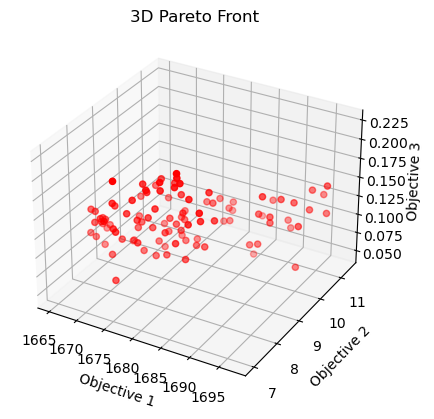

In [3]:
# Plotting the Pareto front in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3D Pareto points
ax.scatter(objective_values[:, 0], objective_values[:, 1], objective_values[:, 2], c='r', marker='o')

ax.set_xlabel('Objective 1')
ax.set_ylabel('Objective 2')
ax.set_zlabel('Objective 3')
plt.title('3D Pareto Front')
plt.show()


# HIGH FIDELITY

C:\Users\rohit\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\rohit\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\rohit\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

Approximate Hypervolume: 85.6207049299377


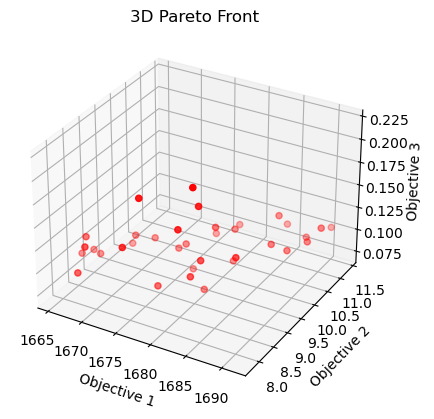

In [7]:
fidelity_levels = [
    {'Phi_f1': 1, 'Phi_f2': 1, 'Phi_f3': 1}   
]

# Run the optimization for each fidelity level and store results
all_results = pd.DataFrame()

for fidelity in fidelity_levels:
    df_results = MOBO(objective_function, cPoI, X_domain, {}, 50, 15, fidelity)
    all_results = pd.concat([all_results, df_results], ignore_index=True)

# Print and save results
all_results.head()
all_results.to_csv("mobo_fidelity_experiments.csv")


# Example data extraction and hypervolume calculation
data = pd.read_csv('mobo_fidelity_experiments.csv')  # Assuming your data is already saved
objective_values = np.stack(data['Objective Values'].apply(eval).values)
reference_point = np.max(objective_values, axis=0) + 1  # Creating a reference point worse than the worst case

# Assuming objective_values already contains only non-dominated points
# If not, filter them as in previous examples
hypervolume = calculate_3d_hypervolume(objective_values, reference_point)
print("Approximate Hypervolume:", hypervolume)

# Plotting the Pareto front in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3D Pareto points
ax.scatter(objective_values[:, 0], objective_values[:, 1], objective_values[:, 2], c='r', marker='o')

ax.set_xlabel('Objective 1')
ax.set_ylabel('Objective 2')
ax.set_zlabel('Objective 3')
plt.title('3D Pareto Front')
plt.show()



# FINAL MODEL

### LOW FIDELITY

Approximate Hypervolume: 95.02318052390768
Pareto front points: [[1.66843506e+03 8.30507425e+00 6.98241888e-02]
 [1.67367615e+03 8.52305239e+00 6.77481452e-02]
 [1.66792615e+03 7.73620751e+00 1.24130674e-01]
 [1.68212127e+03 9.66616088e+00 5.92050914e-02]]


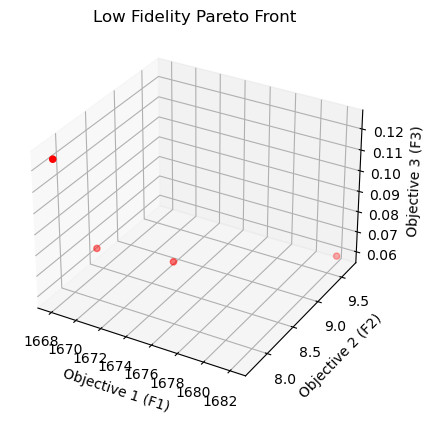

In [48]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from MOMF_problems import MOMF3_5_1

# Initialize the problem
problem = MOMF3_5_1()

def objective_function(x, fidelity):
    x = np.atleast_2d(x)  # Ensure x is 2D for processing
    result = problem.evaluate_MF(x, **fidelity)
    return result['F'].flatten()

def cPoI(models, x, pareto_front, num_samples=100):
    x = np.atleast_2d(x)
    improvements = []
    for model in models:
        mu, sigma = model.predict(x, return_std=True)
        sigma = np.atleast_2d(sigma**2)
        samples = np.random.normal(mu, np.sqrt(sigma), (num_samples, len(mu)))
        improvements.append(np.any([np.all(sample < point) for point in pareto_front for sample in samples]))
    return np.mean(improvements)

def update_pareto_front(current_front, new_point):
    if is_non_dominated(new_point, current_front):
        current_front.append(new_point)
    return current_front

def is_non_dominated(new_point, current_front):
    if len(current_front) == 0:
        return True
    non_dominated = True
    remove = []
    for index, point in enumerate(current_front):
        if np.all(point <= new_point) and np.any(point < new_point):
            non_dominated = False
            break
        if np.all(new_point <= point) and np.any(new_point < point):
            remove.append(index)
    for idx in sorted(remove, reverse=True):
        del current_front[idx]
    return non_dominated

def update_pareto_front(current_front, new_point):
    if is_non_dominated(new_point, current_front):
        current_front.append(new_point)
    return current_front

def MOBO(f, A, X_domain, gamma, Tc, eta, fidelity_setting):
    X = np.random.uniform(X_domain[0], X_domain[1], (eta, 5))
    y = np.array([f(x, fidelity_setting) for x in X])
    results = pd.DataFrame()  # DataFrame to store results
    pareto_front = []

    # Initialize separate GP for each objective
    kernels = [RBF(length_scale=1.0) for _ in range(y.shape[1])]
    models = [GaussianProcessRegressor(kernel=k, random_state=0) for k in kernels]
    
    # Fit models on initial data
    for i, model in enumerate(models):
        model.fit(X, y[:, i])

    for g in range(eta, Tc):
        X_samples = np.random.uniform(X_domain[0], X_domain[1], (1000, 5))
        A_scores = np.array([A(models, x, pareto_front) for x in X_samples])
        x_star = X_samples[np.argmax(A_scores)]
        y_star = f(x_star, fidelity_setting)

        X = np.vstack([X, x_star])
        y = np.vstack([y, y_star])
        
        for i, model in enumerate(models):
            model.fit(X, y[:, i])

        pareto_front = update_pareto_front(pareto_front, y_star.tolist())

        # Append the results for this iteration to the DataFrame
        new_row = pd.DataFrame({
            "Iteration": [g],
            "Fidelity Level": [str(fidelity_setting)],
            "Objective Values": [y_star.tolist()]
        })
        results = pd.concat([results, new_row], ignore_index=True)

    return results


# Define problem domain
X_domain = [np.array([1, 1, 1, 1, 1]), np.array([3, 3, 3, 3, 3])]

# Fidelity levels to test
fidelity_levels = [
    {'Phi_f1': 3, 'Phi_f2': 3, 'Phi_f3': 3}
]

# Run the optimization for each fidelity level and store results
all_results = pd.DataFrame()

for fidelity in fidelity_levels:
    df_results = MOBO(objective_function, cPoI, X_domain, {}, 50, 15, fidelity)
    all_results = pd.concat([all_results, df_results], ignore_index=True)

all_results.head()
all_results.to_csv("mobo_fidelity_experiments.csv")

def identify_pareto(scores):
    # Initialize a list to store the index of points which are non-dominated
    is_pareto = np.ones(scores.shape[0], dtype=bool)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[0]):
            if all(scores[j] <= scores[i]) and any(scores[j] < scores[i]):
                is_pareto[i] = False
                break
    return is_pareto
# Assuming 'results' is your DataFrame and it includes 'Objective Values' as lists of objectives
def safely_eval(val):
    if isinstance(val, str):
        try:
            return eval(val)
        except Exception as e:
            return val  # or handle the error as needed
    return val

# Apply conversion if necessary
objective_values = np.stack(all_results['Objective Values'].apply(safely_eval).values)
reference_point = np.max(objective_values, axis=0) + 1  # Creating a reference point worse than the worst case
hypervolume = calculate_3d_hypervolume(objective_values, reference_point)
print("Approximate Hypervolume:", hypervolume)

pareto_indices = identify_pareto(objective_values)
pareto_points = objective_values[pareto_indices]
print("Pareto front points:" ,pareto_points)

# Plotting the Pareto front in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3D Pareto points
ax.scatter(pareto_points[:, 0], pareto_points[:, 1], pareto_points[:, 2], c='r', marker='o')

# Setting labels for each axis
ax.set_xlabel('Objective 1 (F1)')
ax.set_ylabel('Objective 2 (F2)')
ax.set_zlabel('Objective 3 (F3)')

# Title for the plot
plt.title('Low Fidelity Pareto Front')

# Show the plot
plt.show()



### HIGH FIDELITY

Approximate Hypervolume: 59.69915550530398
Pareto front points: [[1.68052657e+03 8.16534868e+00 1.50801050e-01]
 [1.67389540e+03 9.77149509e+00 9.42091975e-02]
 [1.67859105e+03 9.13971971e+00 9.42964884e-02]
 [1.67797565e+03 9.91347921e+00 8.99728724e-02]
 [1.67794813e+03 8.66857440e+00 1.32878189e-01]
 [1.68301935e+03 9.67403652e+00 9.04728998e-02]
 [1.67392027e+03 9.82124409e+00 9.38993289e-02]
 [1.68273803e+03 9.39978545e+00 9.26548496e-02]
 [1.67894600e+03 8.69271170e+00 9.39718707e-02]
 [1.69118543e+03 1.04104163e+01 8.14601786e-02]
 [1.67893900e+03 8.78007036e+00 9.46502341e-02]
 [1.67367219e+03 9.54099163e+00 1.06295246e-01]
 [1.68160936e+03 1.04186904e+01 7.40915060e-02]
 [1.67524881e+03 9.47696274e+00 1.01428574e-01]]


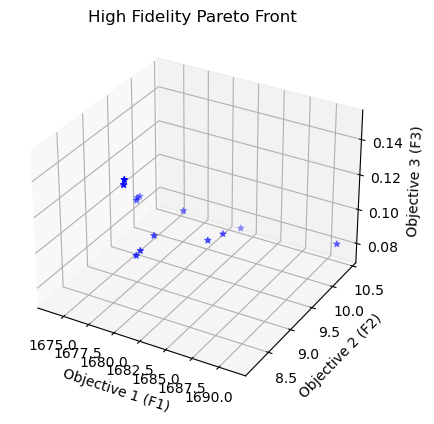

In [49]:
fidelity_levels = [
    {'Phi_f1': 1, 'Phi_f2': 1, 'Phi_f3': 1}
]

# Run the optimization for each fidelity level and store results
all_results = pd.DataFrame()

for fidelity in fidelity_levels:
    df_results = MOBO(objective_function, cPoI, X_domain, {}, 50, 15, fidelity)
    all_results = pd.concat([all_results, df_results], ignore_index=True)

all_results.head()
all_results.to_csv("mobo_fidelity_experiments.csv")


# Apply conversion if necessary
objective_values = np.stack(all_results['Objective Values'].apply(safely_eval).values)
reference_point = np.max(objective_values, axis=0) + 1  # Creating a reference point worse than the worst case
hypervolume = calculate_3d_hypervolume(objective_values, reference_point)
print("Approximate Hypervolume:", hypervolume)

pareto_indices = identify_pareto(objective_values)
pareto_points = objective_values[pareto_indices]
print("Pareto front points:" ,pareto_points)

# Plotting the Pareto front in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3D Pareto points
ax.scatter(pareto_points[:, 0], pareto_points[:, 1], pareto_points[:, 2], c='b', marker='*')

# Setting labels for each axis
ax.set_xlabel('Objective 1 (F1)')
ax.set_ylabel('Objective 2 (F2)')
ax.set_zlabel('Objective 3 (F3)')

# Title for the plot
plt.title('High Fidelity Pareto Front ')

# Show the plot
plt.show()



### MULTI FIDELITY

Approximate Hypervolume: 90.73390902317378
Pareto front points: [[1.67839177e+03 7.94634151e+00 9.22366454e-02]
 [1.67440102e+03 8.54073708e+00 7.83200360e-02]
 [1.67974714e+03 9.41635152e+00 6.00733763e-02]
 [1.67697925e+03 9.23320492e+00 7.45323951e-02]
 [1.66676145e+03 8.12154003e+00 1.02986653e-01]]


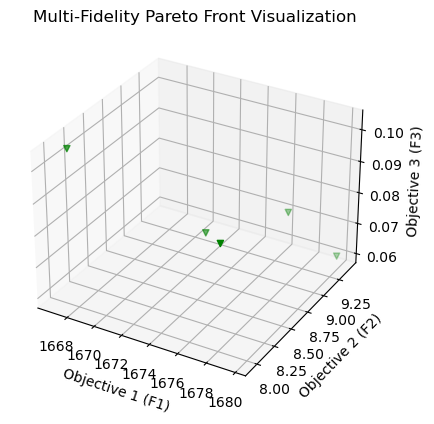

In [47]:
fidelity_levels = [
    {'Phi_f1': 1, 'Phi_f2': 2, 'Phi_f3': 3},
]

# Run the optimization for each fidelity level and store results
all_results = pd.DataFrame()

for fidelity in fidelity_levels:
    df_results = MOBO(objective_function, cPoI, X_domain, {}, 50, 15, fidelity)
    all_results = pd.concat([all_results, df_results], ignore_index=True)

all_results.head()
all_results.to_csv("mobo_fidelity_experiments.csv")


# Apply conversion if necessary
objective_values = np.stack(all_results['Objective Values'].apply(safely_eval).values)
reference_point = np.max(objective_values, axis=0) + 1  # Creating a reference point worse than the worst case
hypervolume = calculate_3d_hypervolume(objective_values, reference_point)
print("Approximate Hypervolume:", hypervolume)

pareto_indices = identify_pareto(objective_values)
pareto_points = objective_values[pareto_indices]
print("Pareto front points:" ,pareto_points)

# Plotting the Pareto front in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3D Pareto points
ax.scatter(pareto_points[:, 0], pareto_points[:, 1], pareto_points[:, 2], c='g', marker='v')

# Setting labels for each axis
ax.set_xlabel('Objective 1 (F1)')
ax.set_ylabel('Objective 2 (F2)')
ax.set_zlabel('Objective 3 (F3)')

# Title for the plot
plt.title('Multi-Fidelity Pareto Front Visualization')

# Show the plot
plt.show()



# DIFFERENT ACQUISTION FUCNTIONS

In [50]:
from scipy.stats import norm
import numpy as np

def expected_improvement(models, x, PF, num_samples=100):
    improvements = []
    x = np.atleast_2d(x)
    for model in models:
        mu, sigma = model.predict(x, return_std=True)
        sigma = np.atleast_2d(sigma**2).flatten()
        best_current = np.min(PF)
        with np.errstate(divide='warn'):
            Z = (mu - best_current) / sigma
            ei = (mu - best_current) * norm.cdf(Z) + sigma * norm.pdf(Z)
        improvements.append(ei)
    return np.mean(improvements)

def probability_of_improvement(models, x, PF, num_samples=100):
    if PF.size == 0:
        return 0  

    improvements = []
    x = np.atleast_2d(x)
    for model in models:
        mu, sigma = model.predict(x, return_std=True)
        sigma = np.atleast_2d(sigma**2)
        best_current = np.min(PF)
        prob_improvement = norm.cdf((mu - best_current) / sigma)
        improvements.append(prob_improvement)
    return np.mean(improvements)

def thompson_sampling(models, x, num_samples=100):
    x = np.atleast_2d(x)
    samples = []
    for model in models:
        mu, sigma = model.predict(x, return_std=True)
        sample = np.random.normal(mu, sigma)
        samples.append(sample)
    return np.mean(samples)  # Using mean as a simple aggregation method


In [51]:
def MOBO(f, A, X_domain, gamma, Tc, eta, fidelity_setting):
    X = np.random.uniform(X_domain[0], X_domain[1], (eta, 5))
    y = np.array([f(x, fidelity_setting) for x in X])
    results = pd.DataFrame()

    # Initialize a separate GP for each objective
    kernels = [RBF(length_scale=1.0) for _ in range(y.shape[1])]
    models = [GaussianProcessRegressor(kernel=k, random_state=0) for k in kernels]
    
    # Fit each model to its respective objective data
    for i, model in enumerate(models):
        model.fit(X, y[:, i])

    # Initialize PF to the worst case if y is empty or use np.min on each column if not
    PF = np.min(y, axis=0) if y.size > 0 else np.full(y.shape[1], np.inf)

    for g in range(eta, Tc):
        X_samples = np.random.uniform(X_domain[0], X_domain[1], (1000, 5))
        A_scores = np.array([A(models, x, PF) for x in X_samples])
        x_star = X_samples[np.argmax(A_scores)]
        y_star = f(x_star, fidelity_setting)

        X = np.vstack([X, x_star])
        y = np.vstack([y, y_star])
        
        for i, model in enumerate(models):
            model.fit(X, y[:, i])

        # Update PF here using a proper updating mechanism
        PF = np.vstack([PF, y_star])
        PF = PF[np.all(PF <= PF[:, np.newaxis], axis=2).any(0)]

        # Append the results for this iteration to the DataFrame
        new_row = pd.DataFrame({
            "Iteration": [g],
            "Fidelity Level": [str(fidelity_setting)],
            "Objective Values": [y_star.tolist()]
        })
        results = pd.concat([results, new_row], ignore_index=True)

    return results


### POE

Approximate Hypervolume: 62.40680544163634
Pareto front points: [[1.69283437e+03 1.12925521e+01 7.73320273e-02]
 [1.67724263e+03 8.68161854e+00 7.90296173e-02]
 [1.67621755e+03 8.05152234e+00 1.37531878e-01]
 [1.67451355e+03 8.79792734e+00 1.39851191e-01]]


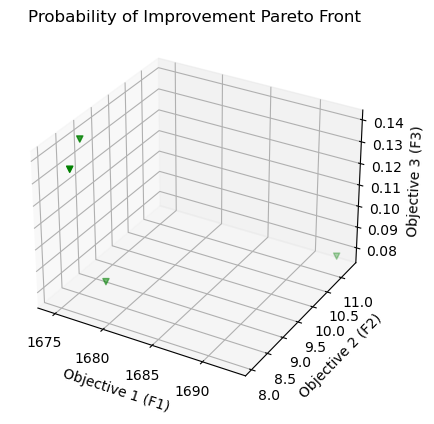

In [52]:
fidelity_levels = [
    {'Phi_f1': 1, 'Phi_f2': 2, 'Phi_f3': 3},
]

# Run the optimization for each fidelity level and store results
all_results = pd.DataFrame()

for fidelity in fidelity_levels:
    df_results = MOBO(objective_function, probability_of_improvement, X_domain, {}, 50, 15, fidelity)
    all_results = pd.concat([all_results, df_results], ignore_index=True)

all_results.head()
all_results.to_csv("mobo_fidelity_experiments.csv")


# Apply conversion if necessary
objective_values = np.stack(all_results['Objective Values'].apply(safely_eval).values)
reference_point = np.max(objective_values, axis=0) + 1  # Creating a reference point worse than the worst case
hypervolume = calculate_3d_hypervolume(objective_values, reference_point)
print("Approximate Hypervolume:", hypervolume)

pareto_indices = identify_pareto(objective_values)
pareto_points = objective_values[pareto_indices]
print("Pareto front points:" ,pareto_points)

# Plotting the Pareto front in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3D Pareto points
ax.scatter(pareto_points[:, 0], pareto_points[:, 1], pareto_points[:, 2], c='g', marker='v')

# Setting labels for each axis
ax.set_xlabel('Objective 1 (F1)')
ax.set_ylabel('Objective 2 (F2)')
ax.set_zlabel('Objective 3 (F3)')

# Title for the plot
plt.title('Probability of Improvement Pareto Front')

# Show the plot
plt.show()



### EI

Approximate Hypervolume: 63.33976495893682
Pareto front points: [[1.67330231e+03 9.38090937e+00 9.93239915e-02]
 [1.68535905e+03 1.00053231e+01 9.31731958e-02]
 [1.67992360e+03 9.10332822e+00 1.35768112e-01]]


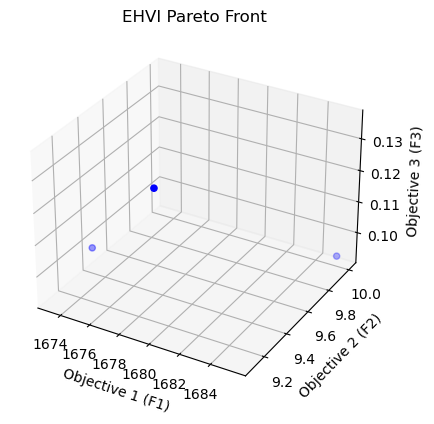

In [55]:
fidelity_levels = [
    {'Phi_f1': 1, 'Phi_f2': 2, 'Phi_f3': 3},
]

# Run the optimization for each fidelity level and store results
all_results = pd.DataFrame()

for fidelity in fidelity_levels:
    df_results = MOBO(objective_function, expected_improvement, X_domain, {}, 50, 15, fidelity)
    all_results = pd.concat([all_results, df_results], ignore_index=True)

all_results.head()
all_results.to_csv("mobo_fidelity_experiments.csv")


# Apply conversion if necessary
objective_values = np.stack(all_results['Objective Values'].apply(safely_eval).values)
reference_point = np.max(objective_values, axis=0) + 1  # Creating a reference point worse than the worst case
hypervolume = calculate_3d_hypervolume(objective_values, reference_point)
print("Approximate Hypervolume:", hypervolume)

pareto_indices = identify_pareto(objective_values)
pareto_points = objective_values[pareto_indices]
print("Pareto front points:" ,pareto_points)

# Plotting the Pareto front in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3D Pareto points
ax.scatter(pareto_points[:, 0], pareto_points[:, 1], pareto_points[:, 2], c='b', marker='o')

# Setting labels for each axis
ax.set_xlabel('Objective 1 (F1)')
ax.set_ylabel('Objective 2 (F2)')
ax.set_zlabel('Objective 3 (F3)')

# Title for the plot
plt.title('EHVI Pareto Front')

# Show the plot
plt.show()



### Thompson Sampling

Approximate Hypervolume: 55.92844685755332
Pareto front points: [[1.68982821e+03 1.14651286e+01 7.14623073e-02]
 [1.68215951e+03 8.86750024e+00 1.65844220e-01]
 [1.67930199e+03 9.26524283e+00 1.28661260e-01]
 [1.68893617e+03 1.03329975e+01 1.11466367e-01]
 [1.69548157e+03 1.08781151e+01 1.04879384e-01]
 [1.69452839e+03 1.14275354e+01 9.93272184e-02]
 [1.69755795e+03 1.08280115e+01 1.07085493e-01]
 [1.70038000e+03 1.07828192e+01 9.30210704e-02]
 [1.69843155e+03 1.06103235e+01 9.92047033e-02]
 [1.70005291e+03 1.11346792e+01 9.71637405e-02]
 [1.69997804e+03 1.05477128e+01 1.10453790e-01]
 [1.70010888e+03 1.06901171e+01 9.54244799e-02]
 [1.69870078e+03 1.01918522e+01 1.17200104e-01]]


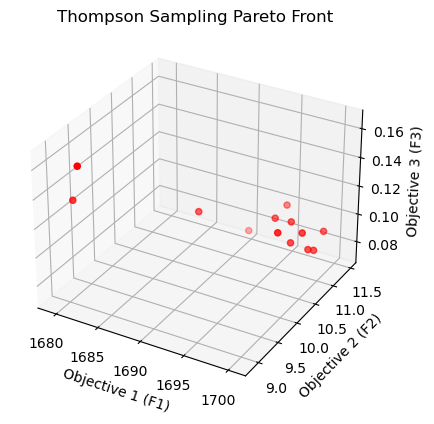

In [56]:
fidelity_levels = [
    {'Phi_f1': 1, 'Phi_f2': 2, 'Phi_f3': 3},
]

# Run the optimization for each fidelity level and store results
all_results = pd.DataFrame()

for fidelity in fidelity_levels:
    df_results = MOBO(objective_function, thompson_sampling, X_domain, {}, 50, 15, fidelity)
    all_results = pd.concat([all_results, df_results], ignore_index=True)

all_results.head()
all_results.to_csv("mobo_fidelity_experiments.csv")


# Apply conversion if necessary
objective_values = np.stack(all_results['Objective Values'].apply(safely_eval).values)
reference_point = np.max(objective_values, axis=0) + 1  # Creating a reference point worse than the worst case
hypervolume = calculate_3d_hypervolume(objective_values, reference_point)
print("Approximate Hypervolume:", hypervolume)

pareto_indices = identify_pareto(objective_values)
pareto_points = objective_values[pareto_indices]
print("Pareto front points:" ,pareto_points)

# Plotting the Pareto front in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3D Pareto points
ax.scatter(pareto_points[:, 0], pareto_points[:, 1], pareto_points[:, 2], c='r', marker='o')

# Setting labels for each axis
ax.set_xlabel('Objective 1 (F1)')
ax.set_ylabel('Objective 2 (F2)')
ax.set_zlabel('Objective 3 (F3)')

# Title for the plot
plt.title('Thompson Sampling Pareto Front')

# Show the plot
plt.show()

